In [165]:
import os
import pandas as pd
from tqdm import tqdm
from hilary.utils import create_classes
from hilary.apriori import Apriori
from hilary.inference import HILARy
from hilary.utils import create_classes, pairwise_evaluation


In [166]:
dataframe = pd.read_csv("/home/athenes/gitlab/HILARy/hilary/tests/data_for_tests/partis_20/single_chain/igh.csv.gz", compression="gzip")


### 3.1 Create apriori object

In [167]:
dataframe = dataframe.rename(
    columns={
        "v_gl_seq": "v_germline_alignment",
        "v_qr_seqs": "v_sequence_alignment",
        "j_gl_seq": "j_germline_alignment",
        "j_qr_seqs": "j_sequence_alignment",
        "clone_id": "ground_truth",
    }
)
dataframe["sequence_id"] = dataframe.index.astype("str")
apriori = Apriori(
    silent=False, threads=-1, sensitivity=0.995, precision=0.995, recenter_mean=True, null_model="vjl",
)


In [168]:
dataframe_processed = apriori.preprocess(df=dataframe, df_kappa=None)


100%|██████████| 3005/3005 [00:06<00:00, 462.62it/s]


In [169]:
apriori.classes = create_classes(dataframe_processed)


In [170]:
apriori.get_histograms(dataframe_processed)


2025-02-05 18:29:59 [debug    ] Computing CDR3 hamming distances within all large VJl classes.


100%|██████████| 2647/2647 [00:02<00:00, 945.37it/s] 


,class_id,0,1,2,3,4,5,6,7,8,...,72,73,74,75,76,77,78,79,80,81
102,102,5,2,5,2,3,6,5,8,12,...,0,0,0,0,0,0,0,0,0,0
106,106,2,3,1,2,8,2,5,6,5,...,0,0,0,0,0,0,0,0,0,0
108,108,8,5,5,2,4,8,8,3,12,...,0,0,0,0,0,0,0,0,0,0
111,111,1,5,6,8,5,5,9,7,18,...,0,0,0,0,0,0,0,0,0,0
112,112,2,5,6,6,4,7,3,4,8,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2825,2825,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2826,2826,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2827,2827,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2828,2828,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [171]:
apriori.get_parameters()


2025-02-05 18:30:04 [debug    ] Computing prevalence and mean distance for all classes


100%|██████████| 2647/2647 [00:13<00:00, 191.39it/s]


In [172]:
hilary = HILARy(apriori, df=dataframe_processed)
dataframe_cdr3 = hilary.compute_prec_sens_clusters(df=dataframe_processed)
dataframe["cdr3_based_family"] = dataframe_cdr3["precise_cluster"]
print(pairwise_evaluation(dataframe, partition="cdr3_based_family"))


2025-02-05 18:30:20 [debug    ] Inferring clusters.            group=['v_gene', 'j_gene', 'cdr3_length']


100%|██████████| 3005/3005 [00:02<00:00, 1135.81it/s]


2025-02-05 18:30:24 [debug    ] Inferring clusters.            group=['v_gene', 'j_gene', 'cdr3_length']


100%|██████████| 3005/3005 [00:02<00:00, 1101.13it/s]


(0.9989794560056795, 0.37258179290714416)


In [173]:

hilary.get_xy_thresholds(df=dataframe_cdr3)
dataframe_inferred = hilary.infer(df=dataframe_cdr3)
dataframe["clone_id"] = dataframe_inferred["clone_id"]


2025-02-05 18:30:29 [debug    ] Group mutations by (v_gene,j_gene,cdr3_length) and compute xy_thresholds.


  0%|          | 0/3183 [00:00<?, ?it/s]

100%|██████████| 3183/3183 [00:10<00:00, 296.25it/s]

2025-02-05 18:30:40 [debug    ] Compute xy_thresholds for each (v_gene,j_gene,cdr3_length) class.



100%|██████████| 3183/3183 [00:05<00:00, 539.56it/s] 


2025-02-05 18:30:47 [debug    ] Marking classes to resolve.


100%|██████████| 1883/1883 [00:03<00:00, 487.95it/s]
/home/athenes/gitlab/HILARy/hilary/inference.py:624: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(value={"to_resolve": False}, inplace=True)


2025-02-05 18:31:08 [debug    ] Checking alignment length.     alignment_length=346
2025-02-05 18:31:08 [debug    ] Inferring family clusters for small groups.


100%|██████████| 8817/8817 [00:12<00:00, 679.43it/s]


2025-02-05 18:31:24 [debug    ] Inferring family clusters for large groups.


In [174]:
dataframe_inferred["ground_truth"]=dataframe["ground_truth"]
dataframe_inferred["cdr3_based_family"]=dataframe["cdr3_based_family"]
print(pairwise_evaluation(dataframe_inferred, partition="clone_id"))


(0.9960893740961769, 0.8093236467142172)


# check prevalence

In [175]:
from hilary.utils import pairwise_evaluation
from scipy.special import binom


In [176]:
apriori_prevalences = []
aposteriori_prevalences=[]
gt_prevalences=[]
precisions=[]
sensitivities = []
number_predicted_clones = []
number_gt_clones = []
len_dfs = []
for i,rows in apriori.classes.iterrows():
    v_gene, j_gene, l = rows[["v_gene","j_gene","cdr3_length"]]
    if v_gene is None or j_gene is None:
        continue
    if v_gene=="None" or j_gene=="None":
        continue
    prevalence = rows["effective_prevalence"]
    apriori_prevalences.append(prevalence)
    df_class = dataframe_inferred.query("v_gene==@v_gene and j_gene==@j_gene and cdr3_length==@l")
    len_dfs.append(len(df_class))
    gt_prevalences.append(binom(df_class.groupby(["ground_truth"]).size(), 2).sum()/binom(len(df_class),2))
    aposteriori_prevalences.append(binom(df_class.groupby(["cdr3_based_family"]).size(), 2).sum()/binom(len(df_class),2))
    precision,sensitivity = pairwise_evaluation(df_class, partition="cdr3_based_family")
    precisions.append(precision)
    sensitivities.append(sensitivity)


/tmp/ipykernel_2462936/1323775730.py:19: RuntimeWarning: invalid value encountered in scalar divide
  gt_prevalences.append(binom(df_class.groupby(["ground_truth"]).size(), 2).sum()/binom(len(df_class),2))
/tmp/ipykernel_2462936/1323775730.py:20: RuntimeWarning: invalid value encountered in scalar divide
  aposteriori_prevalences.append(binom(df_class.groupby(["cdr3_based_family"]).size(), 2).sum()/binom(len(df_class),2))
/tmp/ipykernel_2462936/1323775730.py:19: RuntimeWarning: invalid value encountered in scalar divide
  gt_prevalences.append(binom(df_class.groupby(["ground_truth"]).size(), 2).sum()/binom(len(df_class),2))
/tmp/ipykernel_2462936/1323775730.py:20: RuntimeWarning: invalid value encountered in scalar divide
  aposteriori_prevalences.append(binom(df_class.groupby(["cdr3_based_family"]).size(), 2).sum()/binom(len(df_class),2))
/tmp/ipykernel_2462936/1323775730.py:19: RuntimeWarning: invalid value encountered in scalar divide
  gt_prevalences.append(binom(df_class.groupby([

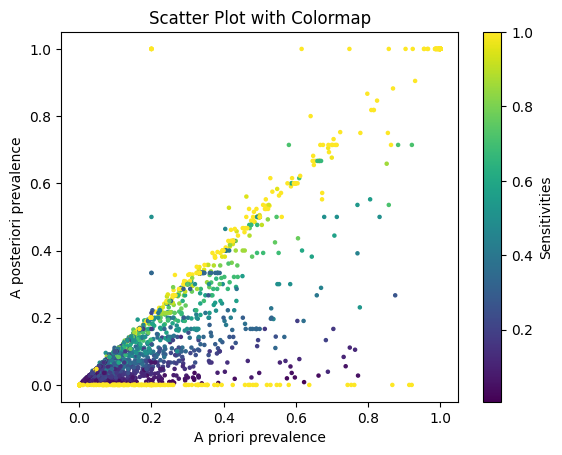

In [177]:
import matplotlib.pyplot as plt

plt.scatter(apriori_prevalences, aposteriori_prevalences, s=5, c=sensitivities, cmap='viridis')
plt.colorbar(label="Sensitivities")  # Add a color bar to indicate the scale
plt.xlabel("A priori prevalence")
plt.ylabel("A posteriori prevalence")
plt.title("Scatter Plot with Colormap")
plt.show()


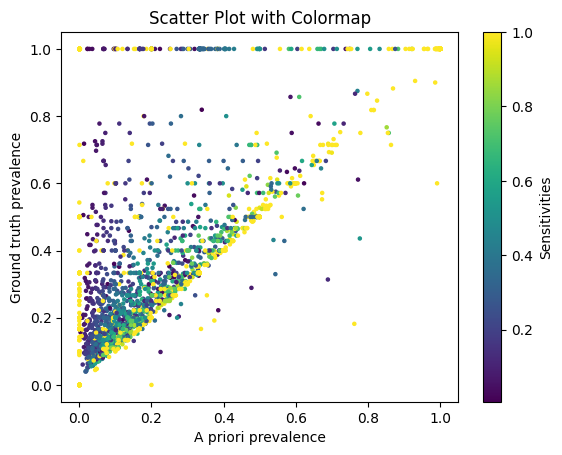

In [178]:
import matplotlib.pyplot as plt

plt.scatter(apriori_prevalences, gt_prevalences, s=5, c=sensitivities, cmap='viridis')
plt.colorbar(label="Sensitivities")  # Add a color bar to indicate the scale
plt.xlabel("A priori prevalence")
plt.ylabel("Ground truth prevalence")
plt.title("Scatter Plot with Colormap")
plt.show()


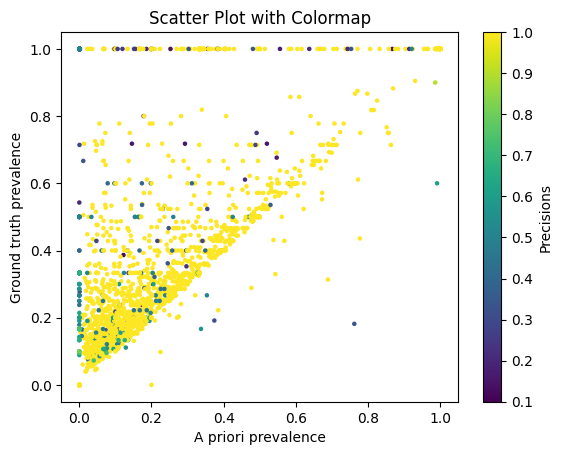

In [179]:
import matplotlib.pyplot as plt

plt.scatter(apriori_prevalences, gt_prevalences, s=5, c=precisions, cmap='viridis')
plt.colorbar(label="Precisions")  # Add a color bar to indicate the scale
plt.xlabel("A priori prevalence")
plt.ylabel("Ground truth prevalence")
plt.title("Scatter Plot with Colormap")
plt.show()


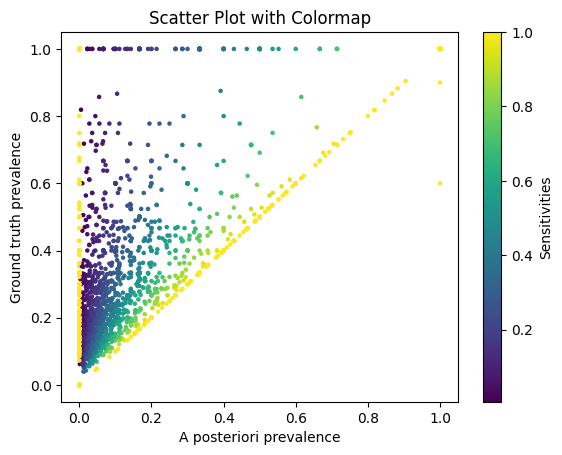

In [180]:
import matplotlib.pyplot as plt

plt.scatter(aposteriori_prevalences, gt_prevalences, s=5, c=sensitivities, cmap='viridis')
plt.colorbar(label="Sensitivities")  # Add a color bar to indicate the scale
plt.xlabel("A posteriori prevalence")
plt.ylabel("Ground truth prevalence")
plt.title("Scatter Plot with Colormap")
plt.show()


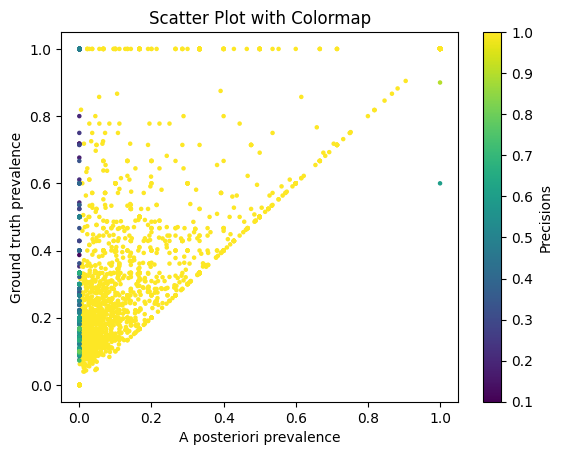

In [181]:
import matplotlib.pyplot as plt

plt.scatter(aposteriori_prevalences, gt_prevalences, s=5, c=precisions, cmap='viridis')
plt.colorbar(label="Precisions")  # Add a color bar to indicate the scale
plt.xlabel("A posteriori prevalence")
plt.ylabel("Ground truth prevalence")
plt.title("Scatter Plot with Colormap")
plt.show()


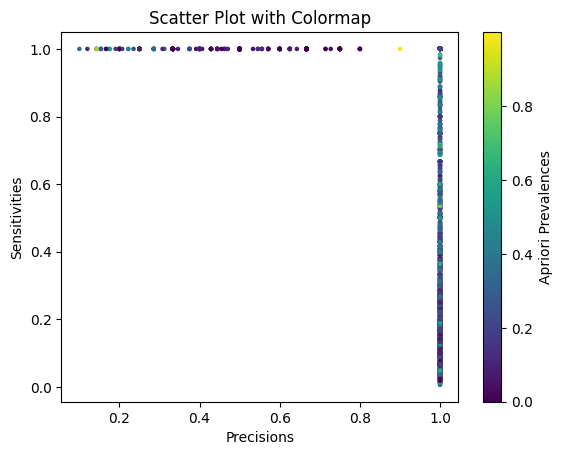

In [182]:
import matplotlib.pyplot as plt

plt.scatter(precisions, sensitivities, s=5, c=apriori_prevalences, cmap='viridis')
plt.colorbar(label="Apriori Prevalences")  # Add a color bar to indicate the scale
plt.xlabel("Precisions")
plt.ylabel("Sensitivities")
plt.title("Scatter Plot with Colormap")
plt.show()


# check null distributions

In [183]:
import numpy as np
muts=[]
counts=[0]*49
for k in range(1000):
    test1 = np.zeros(48)
    for i in range(48):
        if np.random.uniform()<0.2:
            test1[i]=1
    test2 = np.zeros(48)
    for j in range(48):
        if np.random.uniform()<0.2:
            test2[j]=-1
    n_muts=int((test1==test2).sum())
    counts[n_muts]+=1
counts=np.array(counts)/1000


Best model is L


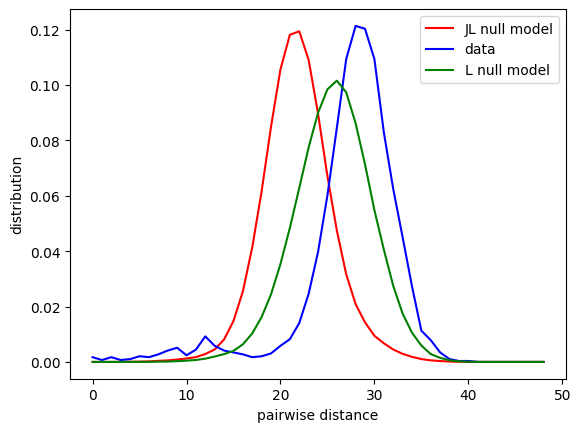

Best model is L


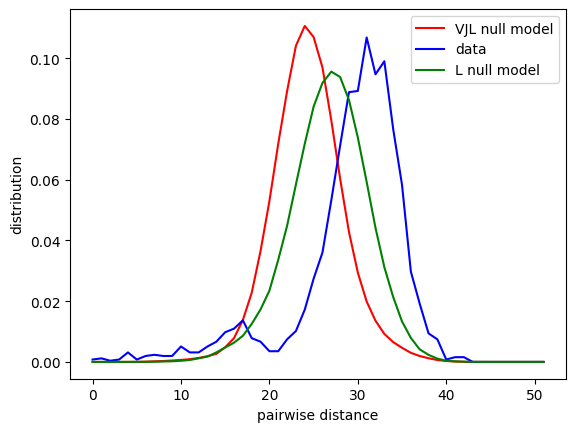

Best model is L


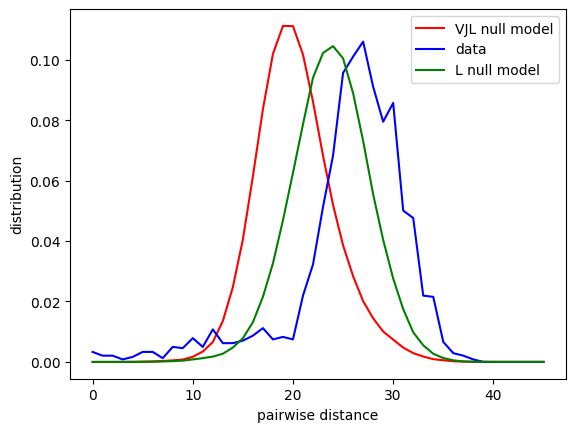

Best model is L


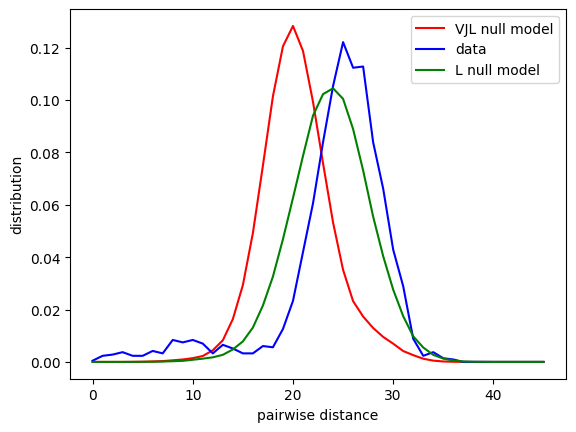

Best model is L


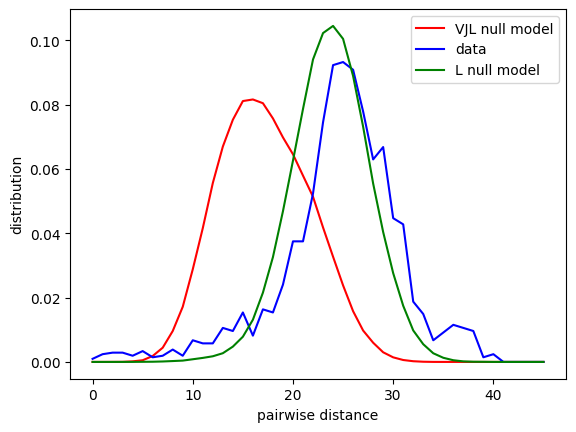

Best model is L


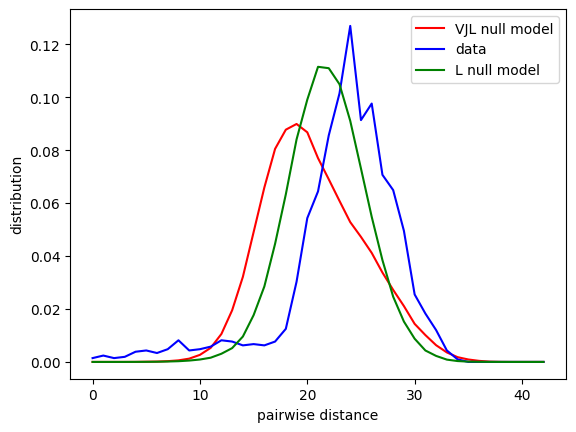

Best model is L


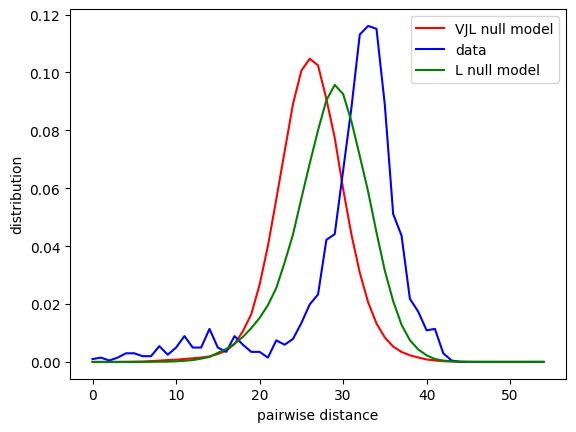

Best model is L


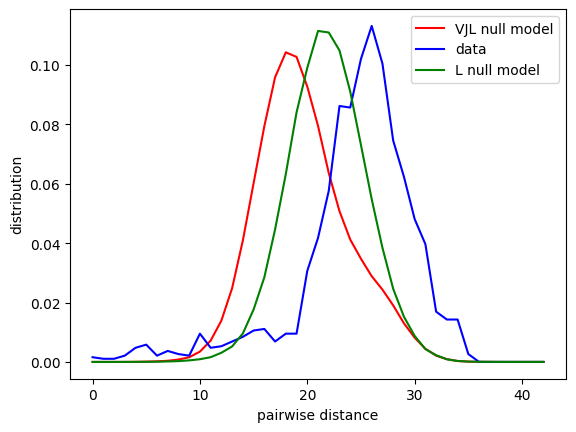

Best model is L


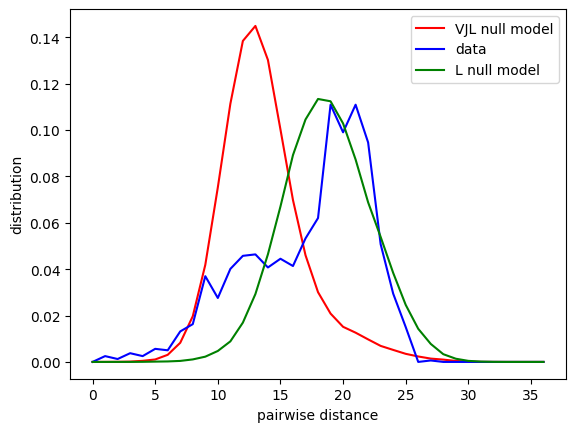

Best model is L


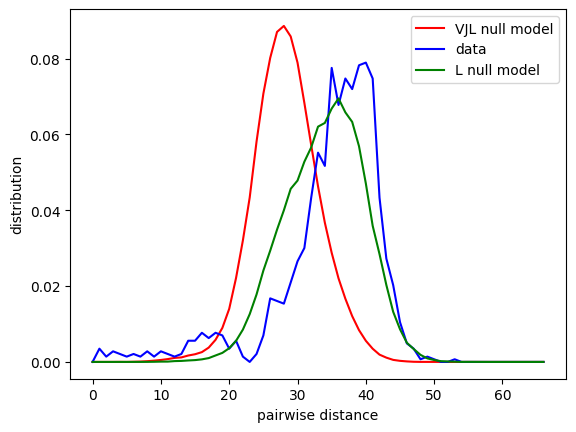

Best model is L


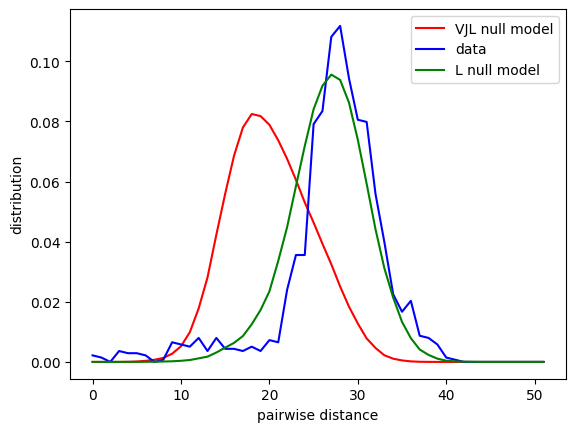

In [184]:
cdf = pd.read_csv("/home/athenes/gitlab/HILARy/hilary/cdfs/cdfs_human_vjl.csv")
compteur=0
for i,rows in apriori.classes.iterrows():
    if compteur>10:
        break
    v_gene, j_gene, l, class_id = rows[["v_gene","j_gene","cdr3_length","class_id"]]
    if v_gene is None or j_gene is None:
        continue
    if v_gene=="None" or j_gene=="None":
        continue

    df_class = dataframe_inferred.query("v_gene==@v_gene and j_gene==@j_gene and cdr3_length==@l")
    precision,sensitivity = pairwise_evaluation(df_class, partition="cdr3_based_family")
    if precision>0.98 and sensitivity>0.98:
        continue
    null_model,mode,bins,cdf0,cdf1,prevalence,fitted_distribution,hist= apriori.return_fit(class_id)
    values = cdf[(cdf["cdr3_length"] == l) & (cdf["j_gene"].isna())].values[0,3:l+3+1]
    print(f"Best model is {null_model}")
    plt.plot(bins, cdf0, color="red", label=f"{mode} null model")
    plt.plot(bins, hist, color="blue", label="data")
    plt.plot(bins, np.diff(values, prepend=0), color="green", label="L null model")

    plt.xlabel("pairwise distance")
    plt.ylabel("distribution")
    plt.legend()

    plt.show()
    plt.close()
    compteur+=1


In [185]:
from hilary.utils import cdf_to_pmf
cdf = pd.read_csv("/home/athenes/gitlab/HILARy/hilary/cdfs/cdfs_human_vjl.csv")
values = cdf_to_pmf(cdf[(cdf["cdr3_length"] == l) & (cdf["j_gene"].isna())].values[0,3:l+3+1])


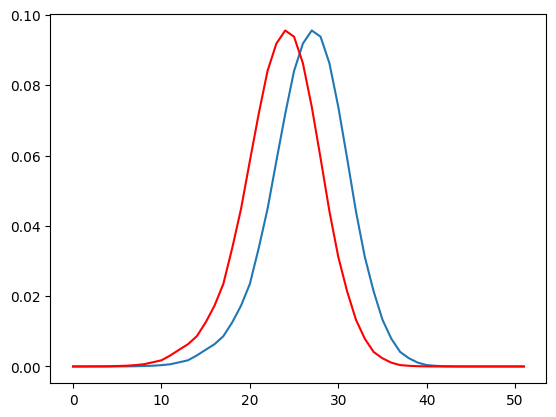

In [186]:
plt.plot(values)
shift=-3
new_values = np.empty_like(values)
if shift>0:
    new_values[:shift]=0
    new_values[shift:]=values[:-shift]
if shift<0:
    new_values[shift:]=0
    new_values[:shift]=values[-shift:]
plt.plot(new_values, color="red")
